In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark
import seaborn as sns
import matplotlib.pyplot as plt


location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col
import pyspark.sql.functions as f

import math

spark = SparkSession \
    .builder \
    .appName("Houses Price") \
    .getOrCreate()

In [2]:
# Carichiamo il data set
trainDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/train.csv', header = 'True', inferSchema='True', nullValue='NA')
testDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/test.csv', header = 'True', inferSchema='True', nullValue='NA')

In [3]:
trainDF.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [4]:
# creo un UDF per contare il numero di elementi nulli all'interno del dataframe divisi per colonna

def null_value_count(df):
  null_columns_counts = []
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [5]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                      PoolQC| 1453|
|                 MiscFeature| 1406|
|                       Alley| 1369|
|                       Fence| 1179|
|                 FireplaceQu|  690|
|                 LotFrontage|  259|
|                  GarageQual|   81|
|                 GarageYrBlt|   81|
|                  GarageCond|   81|
|                GarageFinish|   81|
|                  GarageType|   81|
|                BsmtExposure|   38|
|                BsmtFinType2|   38|
|                    BsmtQual|   37|
|                BsmtFinType1|   37|
|                    BsmtCond|   37|
|                  MasVnrArea|    8|
|                  MasVnrType|    8|
|                  Electrical|    1|
+----------------------------+-----+



In [6]:
# calcolo la percentuale di dati mancanti

nullFeaturesTrainDF = nullFeaturesTrainDF.withColumn( "Missing Ratio",  col("Count") / trainDF.count() * 100)
nullFeaturesTrainDF.show()

+----------------------------+-----+------------------+
|TRAIN Features with NA value|Count|     Missing Ratio|
+----------------------------+-----+------------------+
|                      PoolQC| 1453| 99.52054794520548|
|                 MiscFeature| 1406| 96.30136986301369|
|                       Alley| 1369| 93.76712328767123|
|                       Fence| 1179| 80.75342465753424|
|                 FireplaceQu|  690| 47.26027397260274|
|                 LotFrontage|  259| 17.73972602739726|
|                 GarageYrBlt|   81|5.5479452054794525|
|                  GarageQual|   81|5.5479452054794525|
|                  GarageCond|   81|5.5479452054794525|
|                  GarageType|   81|5.5479452054794525|
|                GarageFinish|   81|5.5479452054794525|
|                BsmtFinType2|   38|2.6027397260273974|
|                BsmtExposure|   38|2.6027397260273974|
|                BsmtFinType1|   37|2.5342465753424657|
|                    BsmtQual|   37|2.5342465753

In [7]:
nullFeaturesTrainDF.groupBy('TRAIN Features with NA value').count().show()


+----------------------------+-----+
|TRAIN Features with NA value|count|
+----------------------------+-----+
|                GarageFinish|    1|
|                  GarageType|    1|
|                    BsmtCond|    1|
|                  GarageQual|    1|
|                       Fence|    1|
|                BsmtFinType1|    1|
|                      PoolQC|    1|
|                BsmtExposure|    1|
|                 MiscFeature|    1|
|                  MasVnrType|    1|
|                BsmtFinType2|    1|
|                 FireplaceQu|    1|
|                       Alley|    1|
|                    BsmtQual|    1|
|                  GarageCond|    1|
|                 LotFrontage|    1|
|                  MasVnrArea|    1|
|                 GarageYrBlt|    1|
|                  Electrical|    1|
+----------------------------+-----+



Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

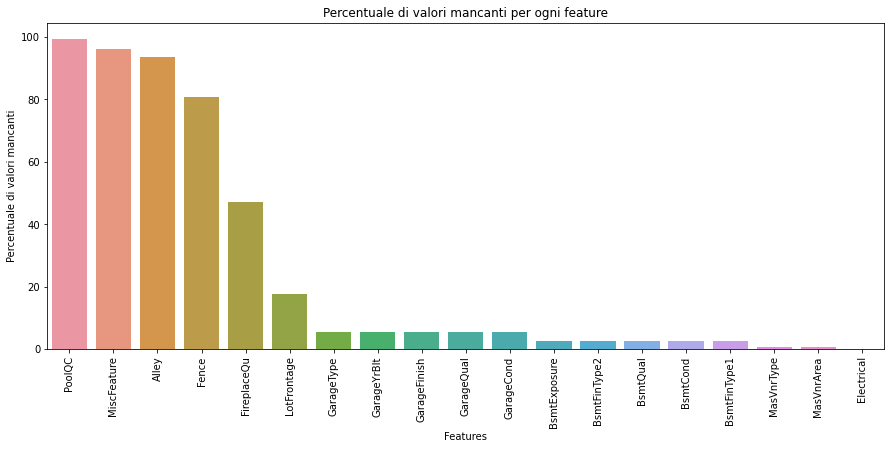

In [8]:
# facciamo un grafico per capire meglio
df_TrainPD = nullFeaturesTrainDF.toPandas()

plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=df_TrainPD['TRAIN Features with NA value'], y=df_TrainPD['Missing Ratio']) 
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [9]:
# cancelliamo le features che hanno una percentuale di valori nulli sopra 80%
dropFeatures = df_TrainPD['TRAIN Features with NA value'][ df_TrainPD['Missing Ratio'] > 80 ] 
print(f'Lista delle features da cancellare:\n{dropFeatures}')

trainDF = trainDF.drop(*dropFeatures)

Lista delle features da cancellare:
0         PoolQC
1    MiscFeature
2          Alley
3          Fence
Name: TRAIN Features with NA value, dtype: object


In [10]:
#cancelliamo le feature droppate anche nel test set
train_cols = list(trainDF.columns)
train_cols.remove('SalePrice')

testDF = testDF[train_cols]

In [11]:
# controlliamo le feature mancanti anche nel test set
nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                FireplaceQu|  730|
|                LotFrontage|  227|
|                 GarageCond|   78|
|               GarageFinish|   78|
|                GarageYrBlt|   78|
|                 GarageQual|   78|
|                 GarageType|   76|
|                   BsmtCond|   45|
|                   BsmtQual|   44|
|               BsmtExposure|   44|
|               BsmtFinType1|   42|
|               BsmtFinType2|   42|
|                 MasVnrType|   16|
|                 MasVnrArea|   15|
|                   MSZoning|    4|
|               BsmtFullBath|    2|
|               BsmtHalfBath|    2|
|                 Functional|    2|
|                  Utilities|    2|
|                Exterior1st|    1|
+---------------------------+-----+
only showing top 20 rows



In [12]:
# controlliamo se le righe in cui il fireplaces è 0 e il valore di fireplaceQu è NA coincida (690 per il train e 730 per il test)
train_fireplaceQu_count = trainDF.where( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ) ).count()
test_fireplaceQu_count = testDF.where( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ) ).count()

print(f'FireplaceQu nel train: {train_fireplaceQu_count}\nFireplaceQu nel test: {test_fireplaceQu_count}\n')

FireplaceQu nel train: 690
FireplaceQu nel test: 730



In [13]:
# settiamo la feature FireplaceQu = 'None'

trainDF = trainDF.withColumn("FireplaceQu", when( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ), "None").otherwise(f.col('FireplaceQu')))
testDF = testDF.withColumn("FireplaceQu", when( ( col('FireplaceQu').isNull() == True) & ( col('Fireplaces') == 0 ), "None").otherwise(f.col('FireplaceQu')))


In [14]:

nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(trainDF), ['TESTFeatures with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                 LotFrontage|  259|
|                  GarageQual|   81|
|                GarageFinish|   81|
|                 GarageYrBlt|   81|
|                  GarageType|   81|
|                  GarageCond|   81|
|                BsmtExposure|   38|
|                BsmtFinType2|   38|
|                    BsmtQual|   37|
|                BsmtFinType1|   37|
|                    BsmtCond|   37|
|                  MasVnrType|    8|
|                  MasVnrArea|    8|
|                  Electrical|    1|
+----------------------------+-----+

+--------------------------+-----+
|TESTFeatures with NA value|Count|
+--------------------------+-----+
|               LotFrontage|  259|
|               GarageYrBlt|   81|
|              GarageFinish|   81|
|                GarageQual|   81|
|                GarageCond|   81|
|                GarageType|   81|
|              Bsm

In [15]:
# creiamo un unico dataframe per calcolare i valori medi o più frequenti

pivotDF = trainDF.drop('SalePrice').union(testDF) # devono avere lo stesso schema, quindi droppiamo la feature SalePrice prima di unirli

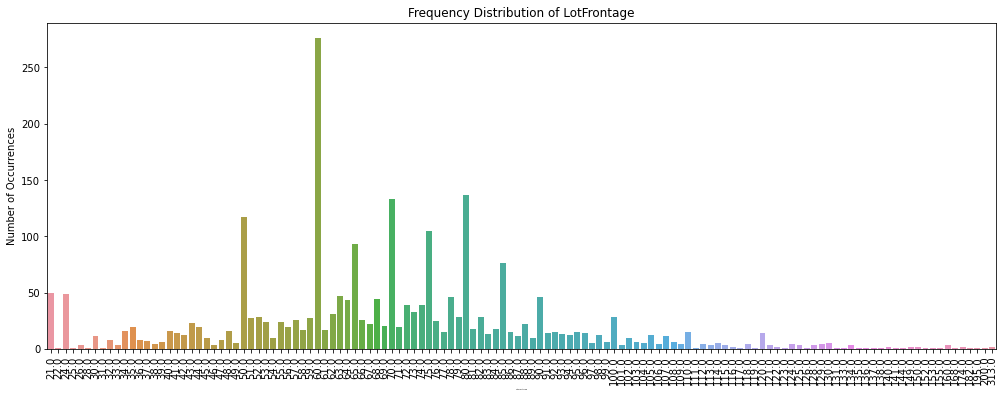

+-------+------------------+
|summary|       LotFrontage|
+-------+------------------+
|  count|              2433|
|   mean| 69.30579531442663|
| stddev|23.344904706927394|
|    min|                21|
|    max|               313|
+-------+------------------+



In [16]:
# vediamo la distribuzione dei valori per questa feature

LotFrontage_count = pivotDF.toPandas()['LotFrontage'].value_counts()
plt.subplots(figsize=(17, 6))
plt.xticks(rotation='90')
sns.barplot(x=LotFrontage_count.index, y=LotFrontage_count.values)
plt.title('Frequency Distribution of LotFrontage')
plt.ylabel('Number of Occurrences' )
plt.xlabel('LotFrontage', fontsize=2)
plt.show()

pivotDF.select('LotFrontage').describe().show()

In [17]:
# Andiamo a settare i valori nulli con il valore più frequente per questa feature

trainDF = trainDF.fillna(LotFrontage_count.index[0], subset=['LotFrontage'])
testDF = testDF.fillna(LotFrontage_count.index[0], subset=['LotFrontage'])

In [18]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                  GarageType|   81|
|                  GarageQual|   81|
|                  GarageCond|   81|
|                 GarageYrBlt|   81|
|                GarageFinish|   81|
|                BsmtExposure|   38|
|                BsmtFinType2|   38|
|                    BsmtCond|   37|
|                    BsmtQual|   37|
|                BsmtFinType1|   37|
|                  MasVnrType|    8|
|                  MasVnrArea|    8|
|                  Electrical|    1|
+----------------------------+-----+

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                 GarageCond|   78|
|                 GarageQual|   78|
|               GarageFinish|   78|
|                GarageYrBlt|   78|
|                 GarageType|   76|
|                   BsmtCond|   45|
|               BsmtExposure|   44|
|         

In [19]:
testDF = testDF\
      .withColumn("GarageCond", when( ( col('GarageType').isNull() == False ) & ( col('GarageFinish').isNull() == True ), "Vito").otherwise(testDF['GarageCond']))


In [20]:
# Se GarageArea e GarageCars sono uguali a 0, il garage non esiste. Riempiamo le righe che rispettano questa condizione settando
# alle features con valore None/0
trainDF = trainDF\
      .withColumn("GarageCond", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageCond')))\
		  .withColumn("GarageQual", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageQual')))\
			  	.withColumn("GarageFinish", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageFinish')))\
					.withColumn("GarageType", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageType')))\
						.withColumn("GarageYrBlt", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), 0).otherwise(f.col('GarageYrBlt')))

testDF = testDF\
      .withColumn("GarageCond", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageCond')))\
		  .withColumn("GarageQual", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageQual')))\
			  	.withColumn("GarageFinish", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageFinish')))\
					.withColumn("GarageType", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), "None").otherwise(f.col('GarageType')))\
						.withColumn("GarageYrBlt", when( ( col('GarageArea') == 0 ) & ( col('GarageCars')== 0 ), 0).otherwise(f.col('GarageYrBlt')))

In [21]:
# nel test set notiamo una conflitto tra il numero di valori mancanti in GarageType con le altre feature riferite sempre al Garage

garage_features = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']
testDF.where( ( col('GarageType').isNull() == False ) & (col('GarageFinish').isNull() == True )).select(garage_features).show()

+-----------+----------+------------+----------+----------+----------+----------+
|GarageYrBlt|GarageType|GarageFinish|GarageQual|GarageCond|GarageArea|GarageCars|
+-----------+----------+------------+----------+----------+----------+----------+
|       null|    Detchd|        null|      null|      Vito|       360|         1|
|       null|    Detchd|        null|      null|      Vito|      null|      null|
+-----------+----------+------------+----------+----------+----------+----------+



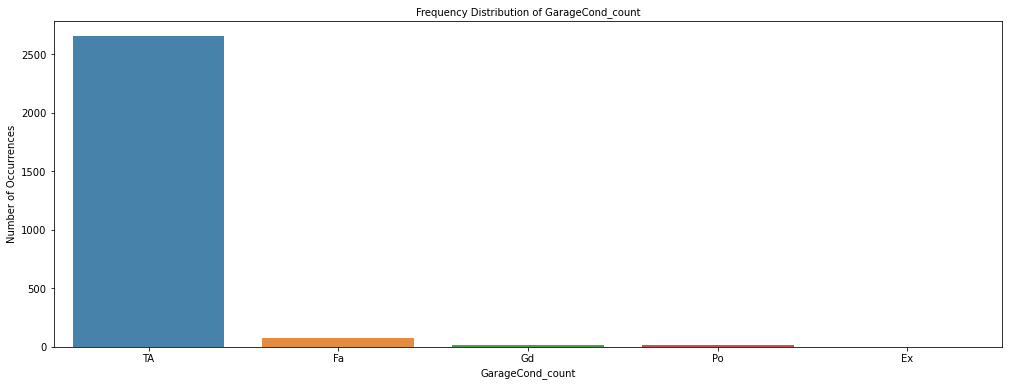

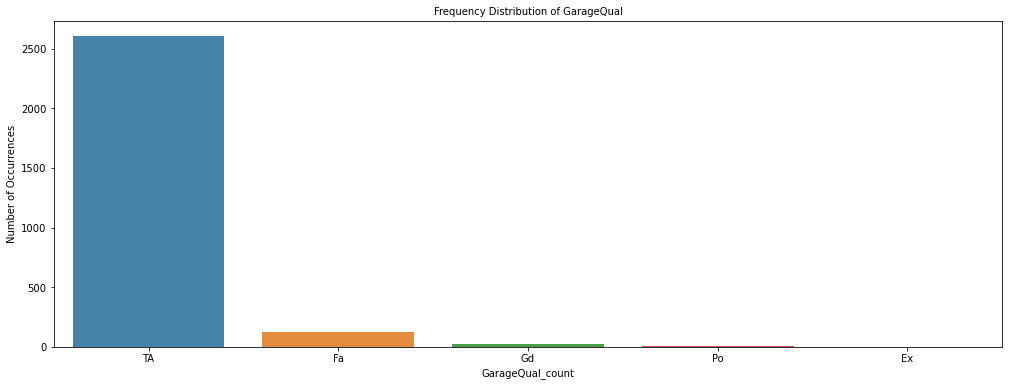

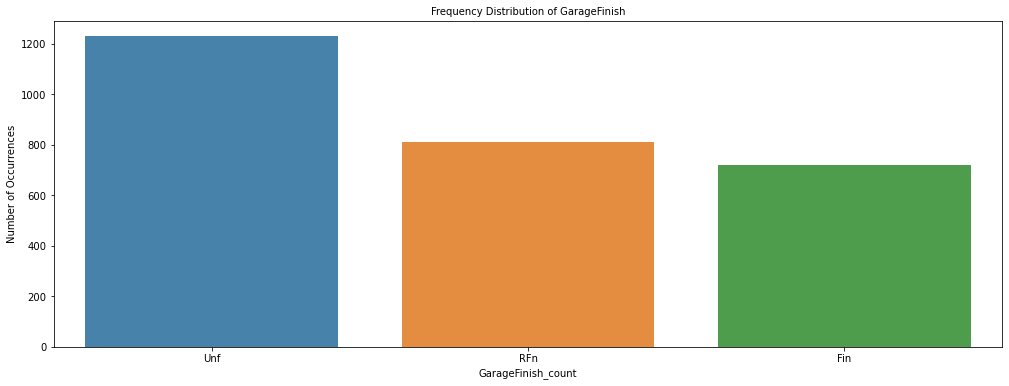

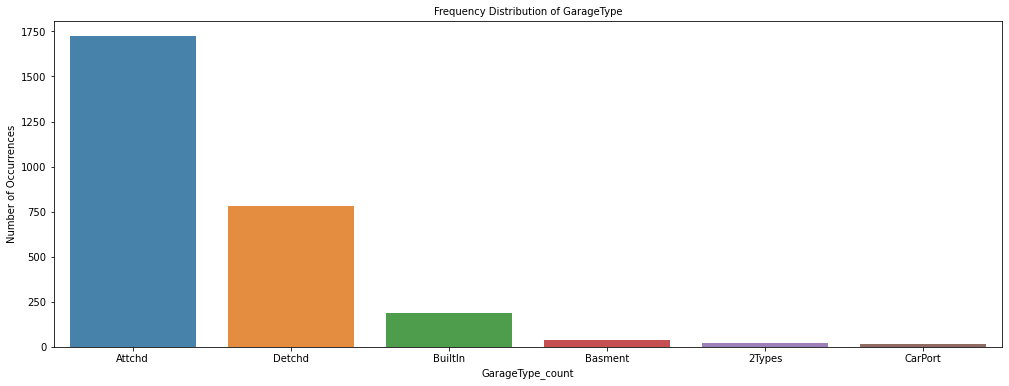

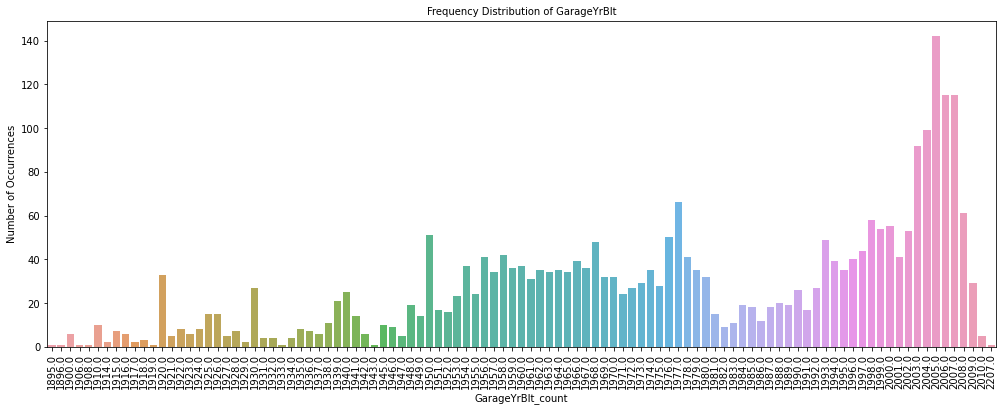

In [22]:
pivotPD = pivotDF.toPandas() # lo convertiamo per fare i grafici

# vediamo il valore più frequente di GarageCond
GarageCond_count = pivotPD['GarageCond'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageCond_count.index, y=GarageCond_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageCond_count', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageCond_count', fontsize=10)
plt.figure(1)

# vediamo il valore più frequente di GarageQual
GarageQual_count = pivotPD['GarageQual'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageQual_count.index, y=GarageQual_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageQual', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageQual_count', fontsize=10)
plt.figure(2)


# vediamo il valore più frequente di GarageFinish
GarageFinish_count = pivotPD['GarageFinish'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageFinish_count.index, y=GarageFinish_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageFinish', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageFinish_count', fontsize=10)
plt.figure(3)


# vediamo il valore più frequente di GarageYrBlt selezionando il GarageType come quella della nostra riga
GarageType_count = pivotPD['GarageType'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageType_count.index, y=GarageType_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageType', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageType_count', fontsize=10)
plt.figure(4)


# vediamo il valore più frequente di GarageYrBlt selezionando il GarageType come quella della nostra riga
GarageYrBlt_count = pivotPD['GarageYrBlt'].value_counts()

plt.subplots(figsize=(17, 6))
sns.barplot(x=GarageYrBlt_count.index, y=GarageYrBlt_count.values, alpha=0.9)
plt.title('Frequency Distribution of GarageYrBlt', fontsize=10)
plt.ylabel('Number of Occurrences', fontsize=10 )
plt.xlabel('GarageYrBlt_count', fontsize=10)
plt.xticks(rotation='90')
plt.figure(5)

plt.show()

In [31]:
# calcoliamo le statistiche
pivotDF.select(garage_features).describe().show()

+-------+------------------+----------+------------+----------+----------+------------------+------------------+
|summary|       GarageYrBlt|GarageType|GarageFinish|GarageQual|GarageCond|        GarageArea|        GarageCars|
+-------+------------------+----------+------------+----------+----------+------------------+------------------+
|  count|              2760|      2762|        2760|      2760|      2760|              2918|              2918|
|   mean|1978.1134057971014|      null|        null|      null|      null| 472.8745716244003|1.7666209732693625|
| stddev|25.574284723905112|      null|        null|      null|      null|215.39481499352166|0.7616243225993496|
|    min|              1895|    2Types|         Fin|        Ex|        Ex|                 0|                 0|
|    max|              2207|    Detchd|         Unf|        TA|        TA|              1488|                 5|
+-------+------------------+----------+------------+----------+----------+------------------+---

In [32]:
avgGarageArea = pivotDF.select(avg(pivotDF.GarageArea)).collect()[0][0]
avgGarageCars = pivotDF.select(avg(pivotDF.GarageCars)).collect()[0][0]
avgGarageYrBlt = pivotDF.select(avg(pivotDF.GarageYrBlt)).collect()[0][0]

print(f'Avg GarageArea: {avgGarageArea}\nAvg GarageCars: {avgGarageCars}\nAvg GarageYrBlt: {avgGarageYrBlt}')

Avg GarageArea: 472.8745716244003
Avg GarageCars: 1.7666209732693625
Avg GarageYrBlt: 1978.1134057971014


In [26]:
# riempiamo le feature mancanti con i valori medi e frequenti calcolati precedentemente

testDF = testDF\
	.fillna(avgGarageYrBlt, subset='GarageYrBlt')\
		.fillna(GarageFinish_count.index[0], subset='GarageFinish')\
			.fillna(GarageQual_count.index[0], subset='GarageQual')\
				.fillna(GarageCond_count.index[0], subset='GarageCond')\
					.fillna(GarageType_count.index[0], subset='GarageType')\
						.fillna(avgGarageArea, subset='GarageArea')\
							.fillna(avgGarageCars, subset='GarageCars')

In [27]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['TRAIN Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

nullFeaturesTestDF = spark.createDataFrame(null_value_count(testDF), ['TEST Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTestDF.show()

+----------------------------+-----+
|TRAIN Features with NA value|Count|
+----------------------------+-----+
|                BsmtFinType2|   38|
|                BsmtExposure|   38|
|                    BsmtQual|   37|
|                BsmtFinType1|   37|
|                    BsmtCond|   37|
|                  MasVnrType|    8|
|                  MasVnrArea|    8|
|                  Electrical|    1|
+----------------------------+-----+

+---------------------------+-----+
|TEST Features with NA value|Count|
+---------------------------+-----+
|                   BsmtCond|   45|
|                   BsmtQual|   44|
|               BsmtExposure|   44|
|               BsmtFinType1|   42|
|               BsmtFinType2|   42|
|                 MasVnrType|   16|
|                 MasVnrArea|   15|
|                   MSZoning|    4|
|                 Functional|    2|
|                  Utilities|    2|
|               BsmtFullBath|    2|
|               BsmtHalfBath|    2|
|              

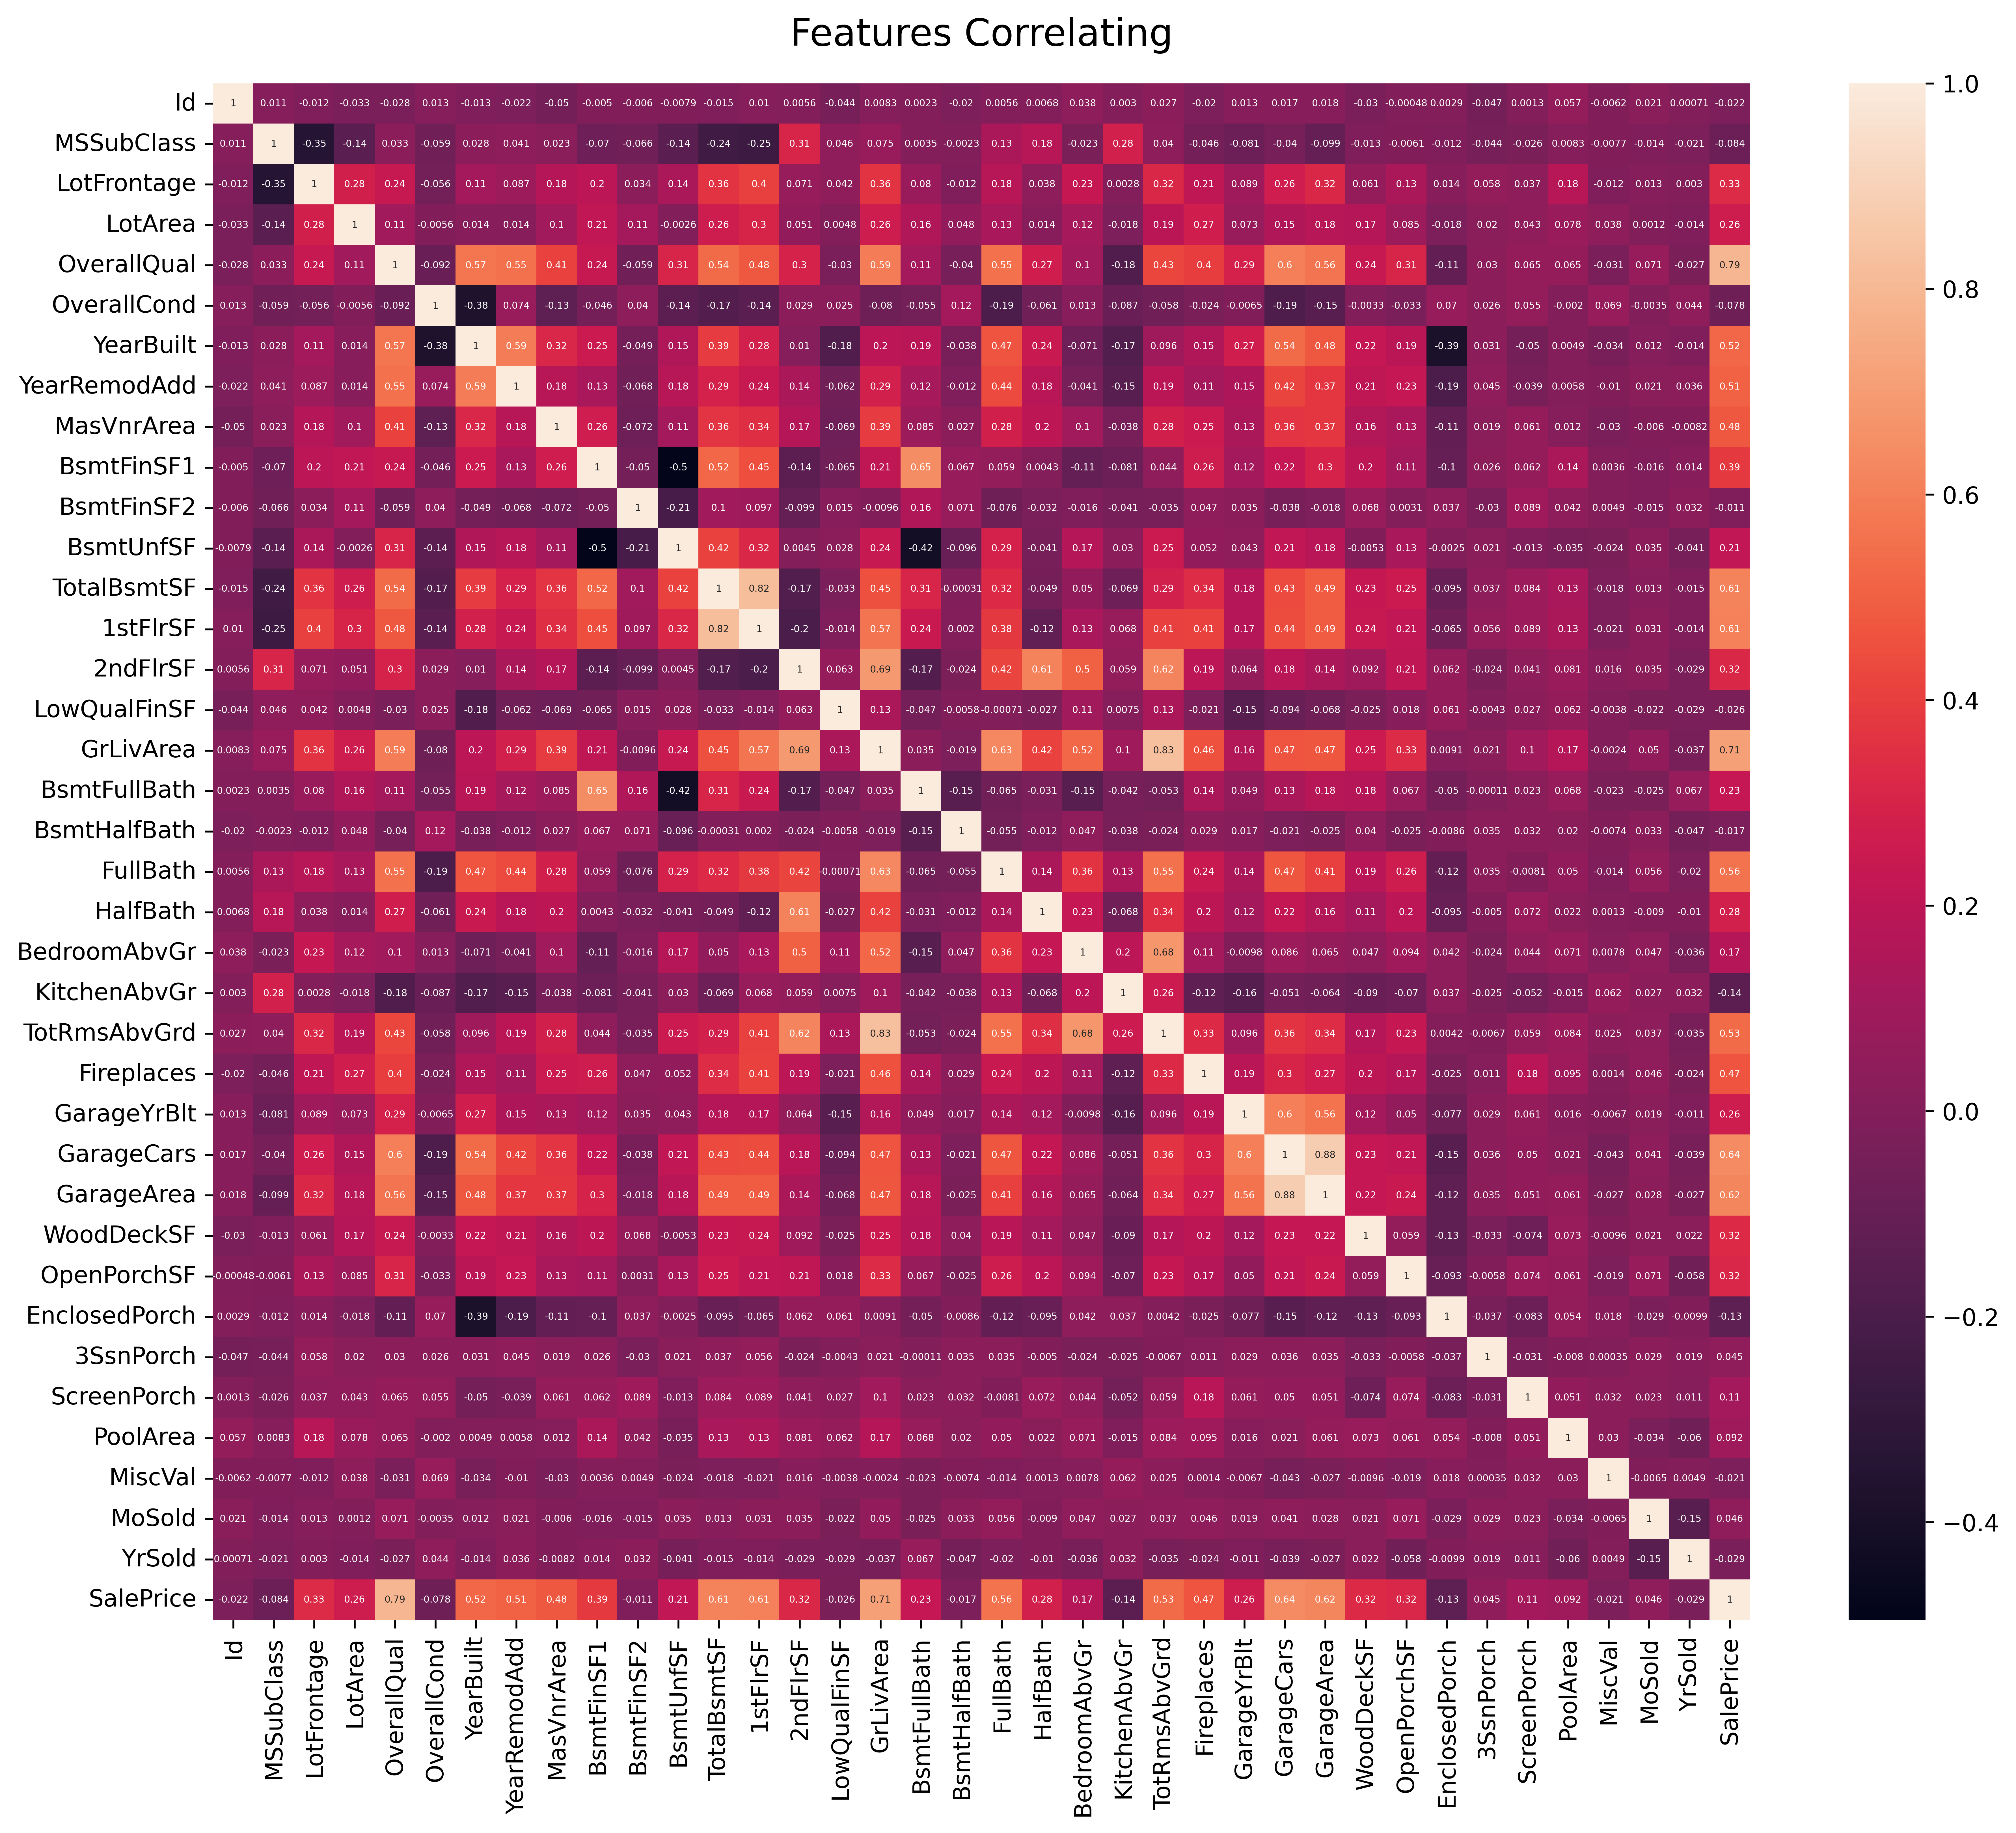

In [28]:
plt.figure(figsize=(15, 12), dpi = 600) 
corr =trainDF.toPandas().corr()
sns.heatmap(corr, annot=True, annot_kws={"fontsize":4}, square=True).set_title('Features Correlating', fontdict={'fontsize':16}, pad=16);

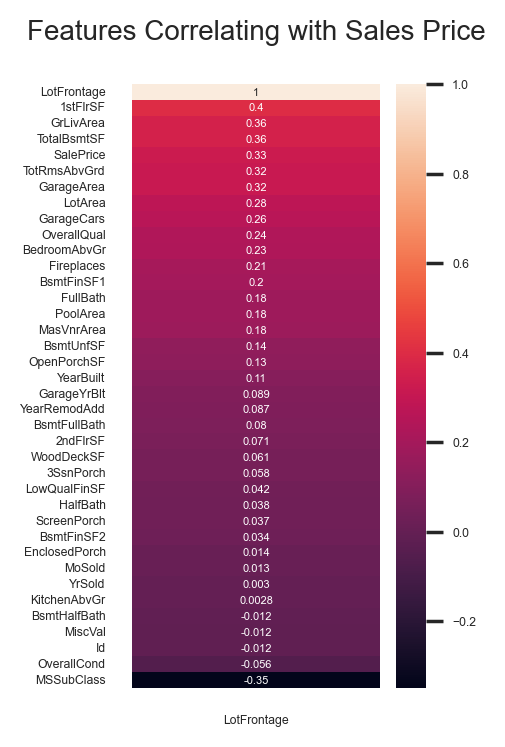

In [29]:
# vediamo la correlazione solo con il prezzo di vendita

corrSP = trainDF.toPandas().corr()[['LotFrontage']].sort_values(by='LotFrontage', ascending=False)

plt.figure(figsize=(2, 4), dpi = 200) 
sns.set(font_scale = 0.4)

sns.heatmap(corrSP, annot=True, annot_kws={"fontsize":4},).set_title('Features Correlating with Sales Price', fontdict={'fontsize':10}, pad=16);

In [30]:
# prendiamo le feature che hanno un valore di correlazione >= 0.5 ed eliminiamo la colonna SalePrice che avrà valore 1 
featuresSelect = corrSP['SalePrice'][ corrSP['SalePrice'] >= 0.5].drop('SalePrice')

print(featuresSelect)

KeyError: 'SalePrice'